# This Script modeling diabetes data for classification possible situation patiente

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pickle
# print(pickle.__version__)

In [2]:
target_col='readmitted'

## Load Data

In [3]:
diabetes = pd.read_csv('../dataset_diabetes/training_diabetic_data.csv')

In [4]:
diabetes = diabetes.drop(columns=['Unnamed: 0','encounter_id'])

In [5]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94668 entries, 0 to 94667
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_nbr               94668 non-null  int64 
 1   race                      94668 non-null  object
 2   gender                    94668 non-null  object
 3   age                       94668 non-null  int64 
 4   admission_type_id         94668 non-null  int64 
 5   discharge_disposition_id  94668 non-null  int64 
 6   admission_source_id       94668 non-null  int64 
 7   time_in_hospital          94668 non-null  int64 
 8   medical_specialty         94668 non-null  object
 9   num_lab_procedures        94668 non-null  int64 
 10  num_procedures            94668 non-null  int64 
 11  num_medications           94668 non-null  int64 
 12  number_outpatient         94668 non-null  int64 
 13  number_emergency          94668 non-null  int64 
 14  number_inpatient      

In [6]:
numeric_columns=[]
categorical_column=[]
for column in diabetes.columns:
    if diabetes[column].dtype in [float, int, 'float64', 'int64'] and column != target_col:
        numeric_columns.append(column)
    elif diabetes[column].dtype in [object] and column != target_col:
        categorical_column.append(column)


In [7]:
transformers = []
numerical_pipeline = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors="coerce"))),
    ("imputer", SimpleImputer(strategy="mean"))
])
transformers.append(("numerical", numerical_pipeline,numeric_columns))



one_hot_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(missing_values=None, strategy="constant", fill_value="")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
transformers.append(("onehot", one_hot_pipeline,categorical_column))

In [8]:
preprocessor = ColumnTransformer(transformers, remainder="passthrough", sparse_threshold=0)

standardizer = StandardScaler()

In [9]:
## Get predictive variables
x_train = diabetes.drop([target_col], axis=1)
## Get target variable
y_train = diabetes[target_col]
## Split training and tetsing set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state = 24, \
                                                                      test_size = 0.1, stratify = y_train)
## Over sample for control inbalance data
oversample = RandomOverSampler(random_state = 12)
x_train, y_train = oversample.fit_resample(x_train, y_train)
x_train = pd.DataFrame(x_train)
x_train.columns = x_train.columns

## Logistic Model

In [10]:
set_config(display="diagram")
## Logistic model
lr_classifier = LogisticRegression(
  penalty = 'l2'
)
## Pipe line for model
model_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", lr_classifier),
])

In [11]:
## Fit model to data
model_lr.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000022460F4BE20>)),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['patient_nbr', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospit...
                                                   'glimepiride',
                                                   'acetohexamide', 'glipizide',
                                                   'glyburide', 'tolbutamide',
                                                   'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin',
                                                   'glipizide-metformin',
                                                   'glimepiride-pioglitazone',
                                                   'metformin-rosiglitazone', ...])])),
                ('standardizer', StandardScaler()),
                ('classifier', LogisticRegression())])

c:\Users\Usuario\Desktop\Agata_test\.conda\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Usuario\Desktop\Agata_test\.conda\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

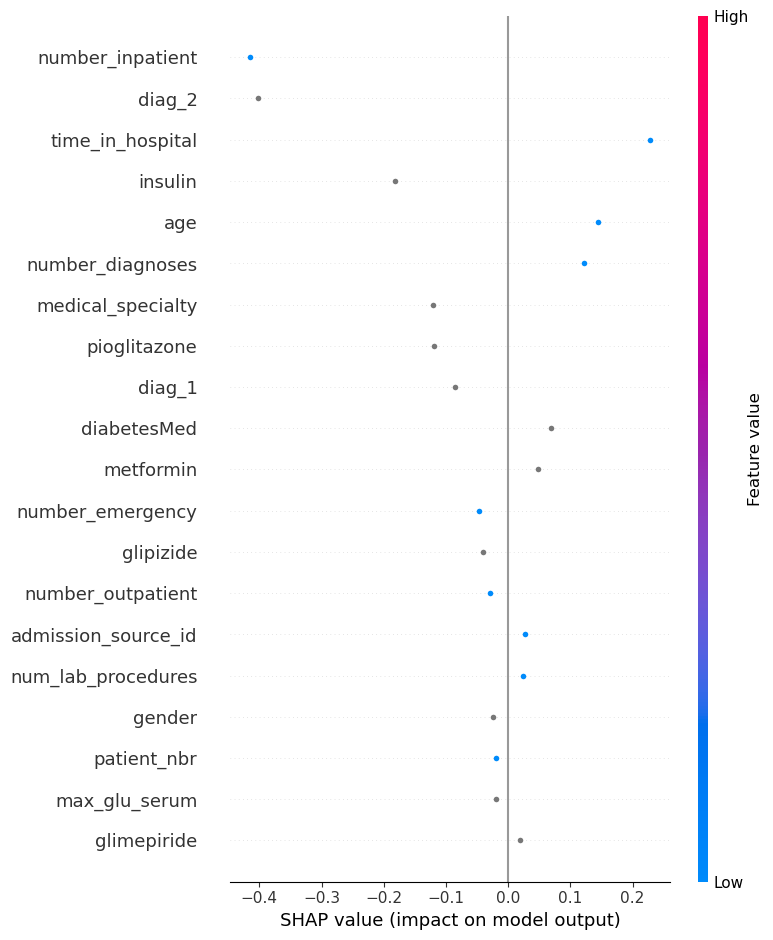

In [12]:
from shap import KernelExplainer, summary_plot
# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = x_train.sample(n=min(100, len(x_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = x_val.sample(n=1)

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: model_lr.predict(pd.DataFrame(x, columns=x_train.columns))
explainer = KernelExplainer(predict, train_sample, link="identity")
shap_values = explainer.shap_values(example, l1_reg=False)
summary_plot(shap_values, example)

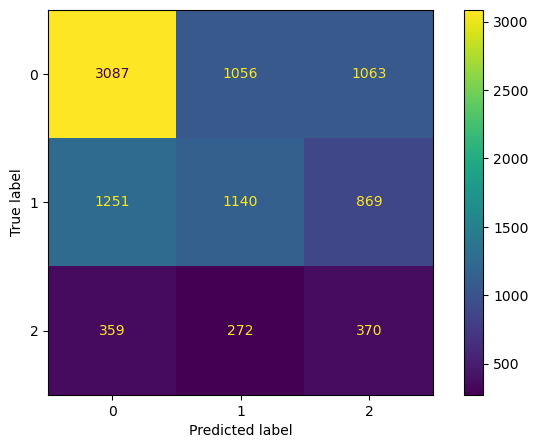

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
# Create the matrix
y_pred= model_lr.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

plt.show()

In [14]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      5206
           1       0.46      0.35      0.40      3260
           2       0.16      0.37      0.22      1001

    accuracy                           0.49      9467
   macro avg       0.43      0.44      0.42      9467
weighted avg       0.54      0.49      0.50      9467



## Stochastic gradient descent

In [15]:
set_config(display="diagram")
## Logistic model
skSGD_classifier = SGDClassifier(
  alpha=0.01,
  eta0 = 0.001,
  learning_rate = 'adaptive', 
  loss = 'log_loss' , 
  penalty = 'elasticnet',
  early_stopping = True
)
## Pipe line for model
model_lm = Pipeline([
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", skSGD_classifier),
])

In [16]:
## Fit model to data
model_lm.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('numerical',
                                                  Pipeline(steps=[('converter',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000022460F4BE20>)),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['patient_nbr', 'age',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospit...
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin',
                                                   'glipizide-metformin',
                                                   'glimepiride-pioglitazone',
                                                   'metformin-rosiglitazone', ...])])),
                ('standardizer', StandardScaler()),
                ('classifier',
                 SGDClassifier(alpha=0.01, early_stopping=True, eta0=0.001,
                               learning_rate='adaptive', loss='log_loss',
                               penalty='elasticnet'))])

100%|██████████| 1/1 [00:04<00:00,  4.32s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


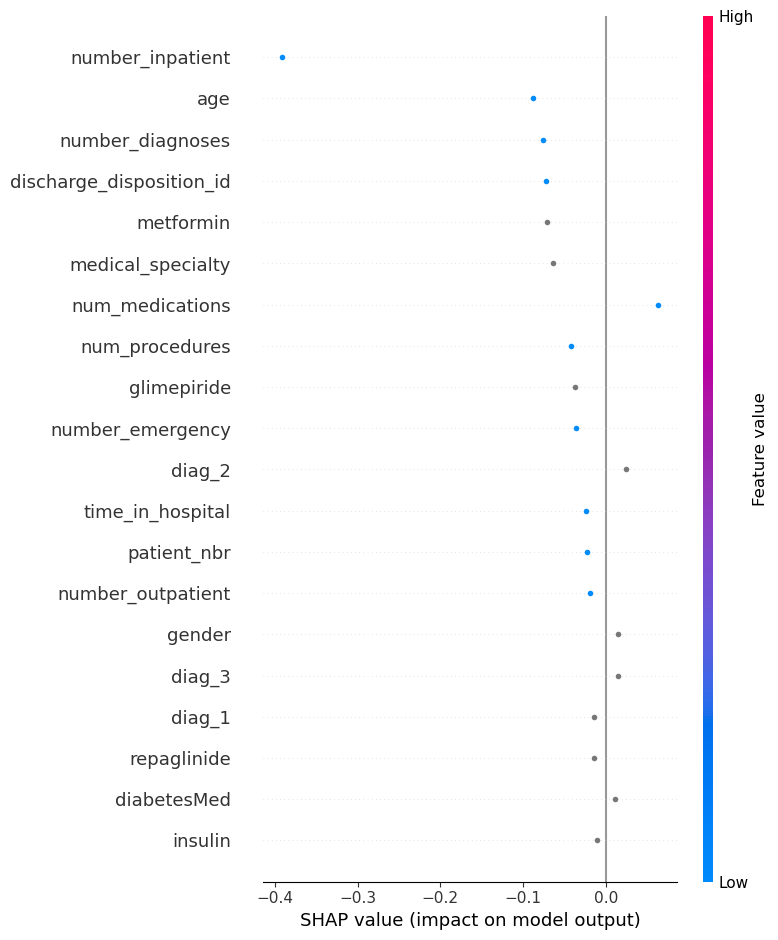

In [17]:
from shap import KernelExplainer, summary_plot
# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = x_train.sample(n=min(100, len(x_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = x_val.sample(n=1)

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: model_lm.predict(pd.DataFrame(x, columns=x_train.columns))
explainer = KernelExplainer(predict, train_sample, link="identity")
shap_values = explainer.shap_values(example, l1_reg=False)
summary_plot(shap_values, example)

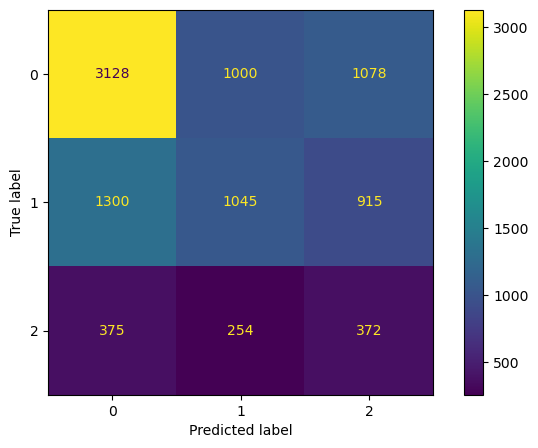

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
# Create the matrix
y_pred= model_lm.predict(x_val)
cm = confusion_matrix(y_val, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

plt.show()

In [19]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.60      0.63      5206
           1       0.45      0.32      0.38      3260
           2       0.16      0.37      0.22      1001

    accuracy                           0.48      9467
   macro avg       0.42      0.43      0.41      9467
weighted avg       0.53      0.48      0.50      9467



## Decision Tree

In [20]:
set_config(display="diagram")
## Standar metrics random forest
dt = DecisionTreeClassifier(max_features = 'sqrt', class_weight = "balanced", random_state = 34, splitter = 'best')
## Hiperparameters grid
dt_params = {"classifier__max_depth": [5, 7, 10,12],
             "classifier__min_samples_split" : range(2, 20, 1),
             }
## Pipeline Process
Pipeline_m = Pipeline([
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", dt),
])
## Created grid with mode, pipeline and hiperparameters for cross-validation
grid_search  = GridSearchCV(Pipeline_m, dt_params, cv=2, n_jobs=-1, scoring = 'accuracy', verbose=2)
## Fit experiments models
dt_cv_model = grid_search.fit(x_train, y_train)
## Print best model
print(dt_cv_model.best_score_)
print(dt_cv_model.best_params_)


Fitting 2 folds for each of 72 candidates, totalling 144 fits
0.45539604271625633
{'classifier__max_depth': 12, 'classifier__min_samples_split': 5}


In [21]:
## Get best model to grid search
best_dt_cv_model = grid_search.best_estimator_

100%|██████████| 1/1 [00:05<00:00,  5.15s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


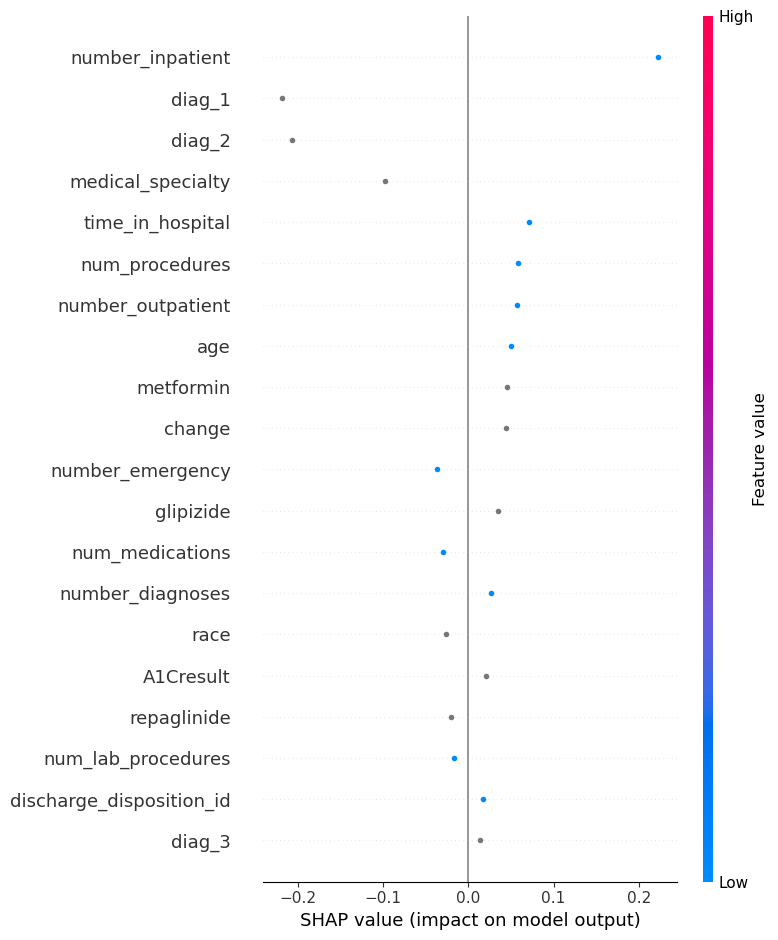

In [22]:
from shap import KernelExplainer, summary_plot
# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = x_train.sample(n=min(100, len(x_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = x_val.sample(n=1)

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: best_dt_cv_model.predict(pd.DataFrame(x, columns=x_train.columns))
explainer = KernelExplainer(predict, train_sample, link="identity")
shap_values = explainer.shap_values(example, l1_reg=False)
summary_plot(shap_values, example)

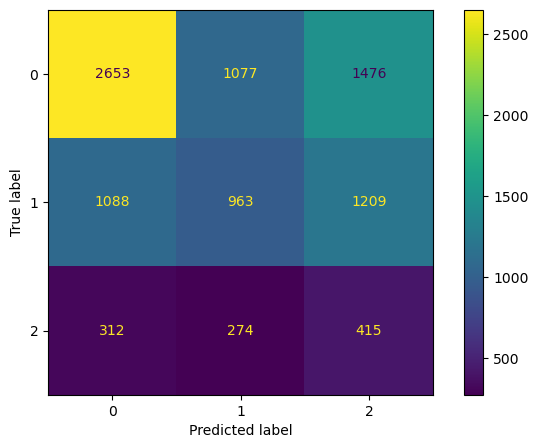

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
# Create the matrix
y_pred= best_dt_cv_model.predict(x_val)
## Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

plt.show()

In [24]:
## Plot report metrics
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57      5206
           1       0.42      0.30      0.35      3260
           2       0.13      0.41      0.20      1001

    accuracy                           0.43      9467
   macro avg       0.40      0.41      0.37      9467
weighted avg       0.52      0.43      0.46      9467



## Random Forest

In [25]:
set_config(display="diagram")
## Standar metrics random forest
rf = RandomForestClassifier(max_features = 'sqrt', max_samples = 0.8, class_weight = "balanced")
## Hiperparameters grid
rf_params = {"classifier__max_depth": [5, 7, 10,12],
             "classifier__n_estimators": range(40, 250, 30),
             }
## Pipeline Process
Pipeline_m = Pipeline([
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", rf),
])
## Created grid with mode, pipeline and hiperparameters for cross-validation
grid_search  = GridSearchCV(Pipeline_m, rf_params, cv=2, n_jobs=-1, scoring = 'accuracy', verbose=2)
## Fit experiments models
rf_cv_model = grid_search.fit(x_train, y_train)
## Print best model
print(rf_cv_model.best_score_)
print(rf_cv_model.best_params_)


Fitting 2 folds for each of 28 candidates, totalling 56 fits
0.5927049217962495
{'classifier__max_depth': 12, 'classifier__n_estimators': 220}


In [26]:
## Get best model to grid search
best_rf_cv_model = grid_search.best_estimator_

100%|██████████| 1/1 [00:10<00:00, 10.92s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


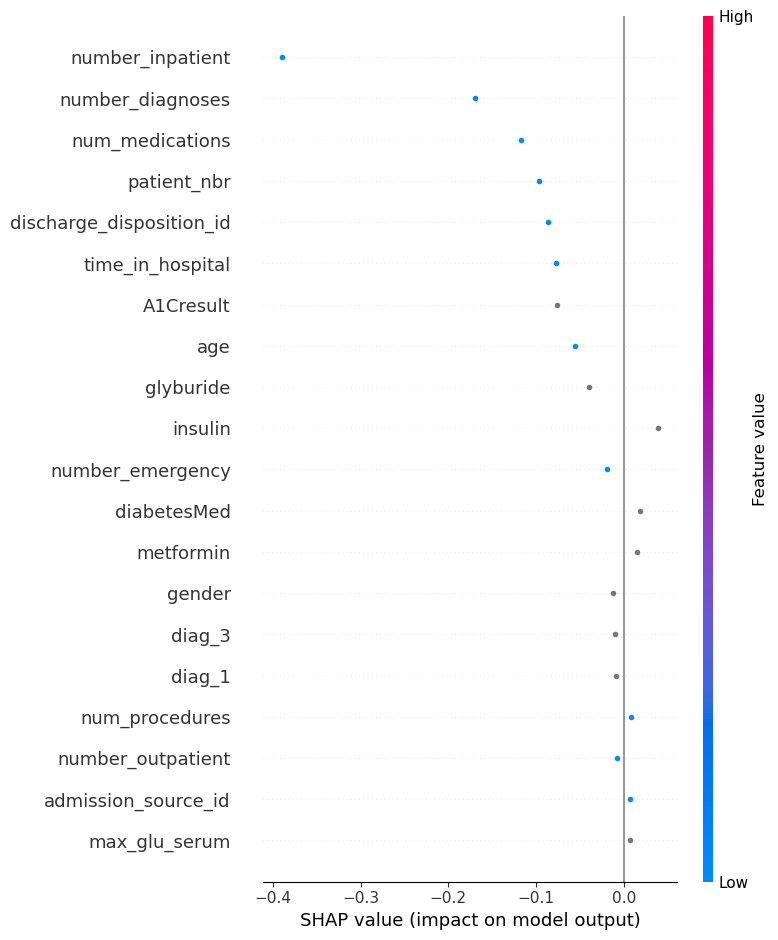

In [27]:
from shap import KernelExplainer, summary_plot
# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = x_train.sample(n=min(100, len(x_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = x_val.sample(n=1)

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: best_rf_cv_model.predict(pd.DataFrame(x, columns=x_train.columns))
explainer = KernelExplainer(predict, train_sample, link="identity")
shap_values = explainer.shap_values(example, l1_reg=False)
summary_plot(shap_values, example)

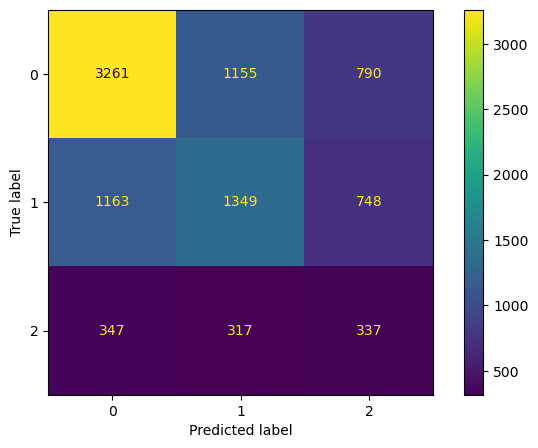

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
# Create the matrix
y_pred= best_rf_cv_model.predict(x_val)
## Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

plt.show()

In [29]:
## Plot report metrics
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65      5206
           1       0.48      0.41      0.44      3260
           2       0.18      0.34      0.23      1001

    accuracy                           0.52      9467
   macro avg       0.45      0.46      0.44      9467
weighted avg       0.56      0.52      0.54      9467



## GradientBoostingClassifier

In [30]:
set_config(display="diagram")
## Standar metrics random forest
gb = GradientBoostingClassifier(max_features = 'sqrt')
## Hiperparameters grid
gb_params = {"classifier__max_depth": [5, 7, 10,12],
             "classifier__n_estimators": range(100, 300, 100),
             "classifier__learning_rate": list(np.linspace(0.0001, 0.01, 5)),

             
             }
## Pipeline Process
Pipeline_m = Pipeline([
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", gb),
])
## Created grid with mode, pipeline and hiperparameters for cross-validation
grid_search  = GridSearchCV(Pipeline_m, gb_params, cv=2, n_jobs=-1, scoring = 'accuracy', verbose=2)
## Fit experiments models
gb_cv_model = grid_search.fit(x_train, y_train)
## Print best model
print(gb_cv_model.best_score_)
print(gb_cv_model.best_params_)


Fitting 2 folds for each of 40 candidates, totalling 80 fits
0.6511359152851409
{'classifier__learning_rate': 0.01, 'classifier__max_depth': 12, 'classifier__n_estimators': 200}


In [31]:
## Get best model to grid search
best_gb_cv_model = grid_search.best_estimator_

100%|██████████| 1/1 [00:31<00:00, 31.73s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


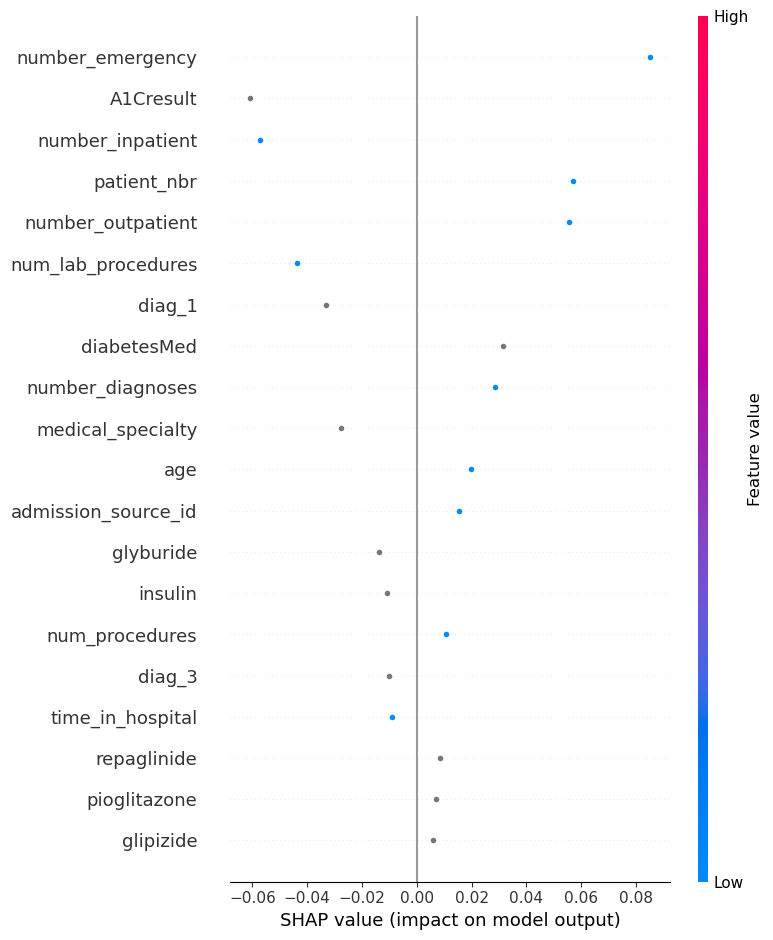

In [32]:
# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = x_train.sample(n=min(100, len(x_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = x_val.sample(n=1)

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: best_gb_cv_model.predict(pd.DataFrame(x, columns=x_train.columns))
explainer = KernelExplainer(predict, train_sample, link="identity")
shap_values = explainer.shap_values(example, l1_reg=False)
summary_plot(shap_values, example)

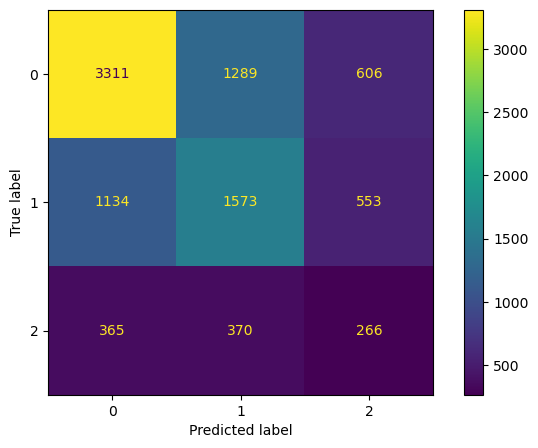

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
# Create the matrix
y_pred= best_gb_cv_model.predict(x_val)
## Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

plt.show()

In [34]:
## Plot report metrics
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66      5206
           1       0.49      0.48      0.48      3260
           2       0.19      0.27      0.22      1001

    accuracy                           0.54      9467
   macro avg       0.45      0.46      0.46      9467
weighted avg       0.57      0.54      0.55      9467



## AdaBoostClassifier

In [45]:
set_config(display="diagram")
## Standar metrics random forest
ab = AdaBoostClassifier()
## Hiperparameters grid
ab_params = {"classifier__learning_rate": list(np.linspace(0.0001, 0.01, 3)),
             "classifier__n_estimators": range(50, 250, 50),
             }
## Pipeline Process
Pipeline_m = Pipeline([
    ("preprocessor", preprocessor),
    ("standardizer", standardizer),
    ("classifier", ab),
])
## Created grid with mode, pipeline and hiperparameters for cross-validation
grid_search  = GridSearchCV(Pipeline_m, ab_params, cv=2, n_jobs=-1, scoring = 'accuracy', verbose=2)
## Fit experiments models
ab_cv_model = grid_search.fit(x_train, y_train)
## Print best model
print(ab_cv_model.best_score_)
print(ab_cv_model.best_params_)


Fitting 2 folds for each of 12 candidates, totalling 24 fits
0.4231461596115128
{'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200}


In [46]:
## Get best model to grid search
best_ab_cv_model = grid_search.best_estimator_

100%|██████████| 1/1 [00:23<00:00, 23.22s/it]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


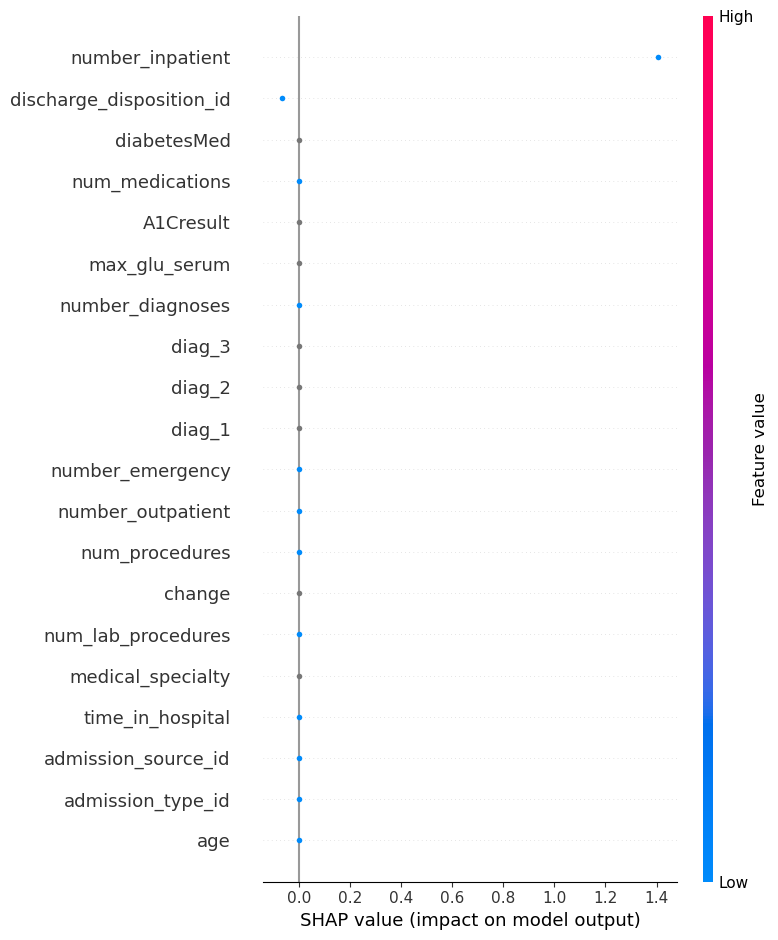

In [47]:
from shap import KernelExplainer, summary_plot
# Sample background data for SHAP Explainer. Increase the sample size to reduce variance.
train_sample = x_train.sample(n=min(100, len(x_train.index)))

# Sample a single example from the validation set to explain. Increase the sample size and rerun for more thorough results.
example = x_val.sample(n=1)

# Use Kernel SHAP to explain feature importance on the example from the validation set.
predict = lambda x: best_ab_cv_model.predict(pd.DataFrame(x, columns=x_train.columns))
explainer = KernelExplainer(predict, train_sample, link="identity")
shap_values = explainer.shap_values(example, l1_reg=False)
summary_plot(shap_values, example)

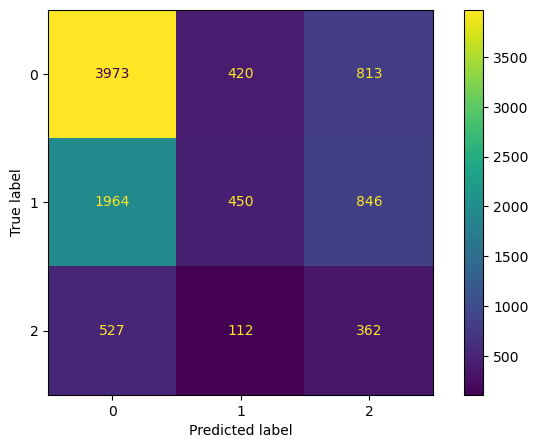

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))
# Create the matrix
y_pred= best_ab_cv_model.predict(x_val)
## Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
cmp = ConfusionMatrixDisplay(cm)
cmp.plot(ax=ax)

plt.show()

In [49]:
## Plot report metrics
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68      5206
           1       0.46      0.14      0.21      3260
           2       0.18      0.36      0.24      1001

    accuracy                           0.51      9467
   macro avg       0.42      0.42      0.38      9467
weighted avg       0.51      0.51      0.47      9467



## Save best models

In [59]:
import dill
import os
filename = 'models/best_rf_cv_model.pkl'
with open(os.path.join(os.getcwd(),filename), 'wb') as file:
    dill.dump(best_rf_cv_model, file)
# save the model to disk
filename = 'models/best_gb_cv_model.pkl'
with open(os.path.join(os.getcwd(),filename), 'wb') as file:
    dill.dump(best_gb_cv_model, file)
# save the model to disk
filename = 'models/best_ab_cv_model.pkl'
with open(os.path.join(os.getcwd(),filename), 'wb') as file:
    dill.dump(best_ab_cv_model, file)

## General conclusions

En general los modelos tienen inconvenientes a la hora de predecir el reingreso menor a 30 dias. Esto en parte se debe al inbalance de los datos, que apesar de generar resample puede generar problema en la prediccion. Ademas, aprece que no hay tantas diferencias entre los pacientes que reingresan en menoso de 30 dias y aquellos que no reingresan. Puede que un set mas amplio o mayores carateristicas puedan mejorar la prediccion.

Adicioanal este trabajo puede mejorar de dos formas:

1. Generando transformacion de la variables actuales  que permitan ser mas eficiente al modelo
2. Probando mas arquitecturas o algoritmos, para encontrar mejores metricas de ajuste

Conclusiones de las varables relevantes:
1. number_inpatient es la variable con mayor poder predictivo. Es decir, debe ser prioridad en la recoleccion de datos para prediccion. Que un paciente se hospitalice varias veces puede ser signo de alarma que el tratamiento para la diabetes no vaya funcionar correctamente
2. La razon de salida de hospitalizacion tambien afecta la probabiliad de que el paciente vuelva a ingresar.
3.  En algunos modelos el numerode emergencia del paciente , tambien puede ser un signo de alarma.
